In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [2]:
#XOR Data Generation
n=10000
np.random.seed(0)
data= (2*np.random.uniform(size=(10000,2)) - 1).astype('float32')
 
labels= ((data[:,0]*data[:,1])<0).astype('int64')
print(data.shape)

(10000, 2)


In [3]:
#To split dataset as train : cv : test = 70:15:15
from sklearn.model_selection import train_test_split

length= len(data)
train_ratio= 0.7
cv_ratio= 0.15
test_ratio= 0.15

train_length= int(train_ratio*length)
cv_length= int(cv_ratio*length)
test_length= length- train_length - cv_length

#Train-Test
X_train, X_test, y_train, y_test= train_test_split(data, labels, shuffle= True,\
                                                   train_size= train_ratio)
#CV-Test
X_cv, X_test, y_cv, y_test= train_test_split(X_test, y_test, shuffle= True,\
                                    train_size= cv_ratio/(cv_ratio+test_ratio))

In [4]:
class XORDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data= data
        self.labels= labels
 
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx= idx.toList()
        
        datapoints=self.data[idx]
        labels= self.labels[idx]
        sample= (datapoints, labels)
 
        return sample

In [5]:
#Initialising GPU for Computations
#torch.cuda.get_device_name(0)
#cuda0= torch.device('cuda:0')

In [6]:
train= XORDataset(X_train, y_train)
cv= XORDataset(X_cv, y_cv)
test_data= XORDataset(X_test, y_test)

In [7]:
for i in range(len(train)):
    sample = train[i]

    print(i, sample[0].shape, sample[1].shape)
    if i == 4:
        break

0 (2,) ()
1 (2,) ()
2 (2,) ()
3 (2,) ()
4 (2,) ()


In [8]:
#Defining DataLoader
from torch.utils.data import DataLoader 

trainloader= DataLoader(train, batch_size= 16, shuffle= True, drop_last= False)
cvloader= DataLoader(cv, batch_size=16, shuffle=True, drop_last=False)
testloader= DataLoader(test_data, batch_size=16, shuffle=True, drop_last= False)

In [9]:
import torch.nn.functional as F
import torch.nn as nn
from torch import optim

#Defining Neural Network Architecture
class NeuralNetwork1(nn.Module):
    def __init__(self, hidden_layer_size=4):
        super(NeuralNetwork1, self).__init__()
        torch.manual_seed(0)
        self.layer1= nn.Linear(2, hidden_layer_size)
        self.layer2= nn.Linear(hidden_layer_size, 2)

    def forward(self, X):
        a1= self.layer1(X)
        h1= F.relu(a1)
        a2=self.layer2(h1) #CrossEntropyLoss includes the softmax!
        #h2= torch.exp(a2)/torch.exp(a2).sum(-1).unsqueeze(-1) #SoftMax Function
        return a2#,h2

In [12]:
loss_function= nn.CrossEntropyLoss()
class Model():
    def __init__(self, nnModel, epochs, lr):
        self.nnModel= nnModel
        self.epochs= epochs
        self.lr= lr
        self.train_loss_arr=[]
        self.val_loss_arr= []
        self.test_loss= 0
        self.train_accuracy=[]
        self.val_accuracy=[]
        self.test_accuracy=0 
    
    def fit(self):
        nnModel= self.nnModel
        optimiser= optim.SGD(self.nnModel.parameters(), lr= self.lr)
        for epoch in range(self.epochs):
            #This is written because we're fitting it w.r.t nn1 architecture 
            #And so that gradient calculations can be done properly
            
            #Training Begins
            nnModel.train()
            total_train_loss=0
            correct_predict=0
            for batch in trainloader:
                X= batch[0]#.to(cuda0)
                y= batch[1]#.to(cuda0)
                optimiser.zero_grad()
                y_pred= nnModel(X)#.to(cuda0)

                #To get accuracy of train set
                prediction= torch.argmax(y_pred, dim=1) 
                correct_predict+= (prediction==y).sum().item()
                
                #For Train Loss
                loss= loss_function(y_pred,y)
                total_train_loss+= loss.item() #Since it is a tensor
                loss.backward() #Because we're doing batch G.D so not total_loss
                optimiser.step()
            
            acc= 100*correct_predict/train_length
            self.train_accuracy.append(acc)
            total_train_loss/= len(X_train)
            self.train_loss_arr.append(total_train_loss)
                
            #Cross Validation Begins
            total_val_loss=0
            nnModel.eval() #Ensures that no gradients are being calculated
            correct_predict=0
            for batch in cvloader:
                X= batch[0]#.to(cuda0)
                y= batch[1]#.to(cuda0)
                y_val_pred= nnModel(X)#.to(cuda0)

                #To get accuracy of Validation set
                prediction= torch.argmax(y_val_pred, dim=1) 
                correct_predict+= (prediction==y).sum().item()

                #For Validation Loss
                loss= loss_function(y_val_pred, y)
                total_val_loss+= loss.item()
            
            acc= 100*correct_predict/cv_length
            self.val_accuracy.append(acc)
            total_val_loss/= len(X_cv)
            self.val_loss_arr.append(total_val_loss)
            
            print(f"Epoch-->{epoch} Training Error = {total_train_loss} CrossVal Error = {total_val_loss}")

    def test(self):
        #total_test_loss=0
        correct_predict=0
        with torch.no_grad():
            for batch in testloader:
                X= batch[0]#.to(cuda0)
                y= batch[1]#.to(cuda0)
                output_prob= self.nnModel(X)
                
                #Finds position of maxium probability, which is actually 
                #The predicted class
                prediction= torch.argmax(output_prob, dim=1) 
                correct_predict+= (prediction==y).sum().item()

                #To get Test Loss
                loss= loss_function(output_prob, y)
                self.test_loss+= loss.item()
        
        self.test_loss/= test_length
        self.test_accuracy=100*correct_predict/test_length
        print("Test Set Accuracy is : %.3f"%self.test_accuracy)

**I've actually divided all the losses, train, test, validation, by the number of samples each of the losses had to give in essence an average loss over the entire dataset's train/ test/ validation** 

Please Consider it! It isn't a mistake, It just seemed more appropriate to compare Validation and Train Loss by their average and not just

In [13]:
#Yes I know I've later divided the loss functions by the number of samples 
#For each Train/Val/ Test sets, it isn't a mistake! Please consider it!
#I know it was asked to report oss, but I found it more appropriate to compare
#The average losses (Loss divided by number of samples) rather than the entire
#Magnitude because of different sample sizes!

nn1= NeuralNetwork1(hidden_layer_size=4)
nn1#.to(cuda0)
model1= Model(nn1, epochs=100, lr=1e-3)
model1.fit()

Epoch-->0 Training Error = 0.04609940168687276 CrossVal Error = 0.04652548356850942
Epoch-->1 Training Error = 0.045242286545889715 CrossVal Error = 0.045624168554941814
Epoch-->2 Training Error = 0.04462897413117545 CrossVal Error = 0.04494093879063924
Epoch-->3 Training Error = 0.044157615721225736 CrossVal Error = 0.044420095324516295
Epoch-->4 Training Error = 0.04378278121777943 CrossVal Error = 0.043993491808573405
Epoch-->5 Training Error = 0.04346645925726209 CrossVal Error = 0.043629745165507
Epoch-->6 Training Error = 0.043201861373015814 CrossVal Error = 0.04332482361793518
Epoch-->7 Training Error = 0.04296210263456617 CrossVal Error = 0.0430716149409612
Epoch-->8 Training Error = 0.042748685930456436 CrossVal Error = 0.042838683406511945
Epoch-->9 Training Error = 0.04255700675078801 CrossVal Error = 0.04262504247824351
Epoch-->10 Training Error = 0.04237042279754366 CrossVal Error = 0.042422567486763
Epoch-->11 Training Error = 0.04219911241531372 CrossVal Error = 0.04223

In [14]:
model1.test()
model1.test_loss

Test Set Accuracy is : 91.533


0.019631301154692967

#**Q8)a) Plot of Test and Val Loss vs Epochs**

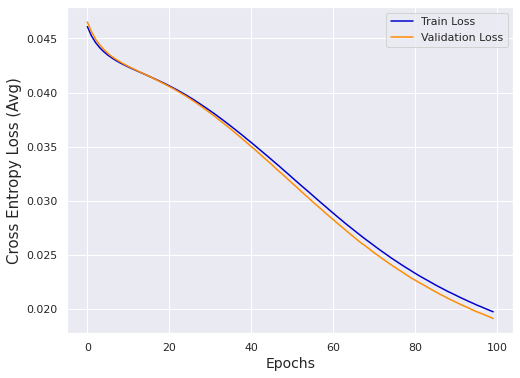

In [32]:
plt.subplots(figsize=(8,6))
plt.plot(model1.train_loss_arr, color='mediumblue',label='Train Loss')
plt.plot(model1.val_loss_arr, color='darkorange',label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.ylabel('Cross Entropy Loss (Avg)', size=15)
plt.show()

If you want NON AVERAGED LOSS

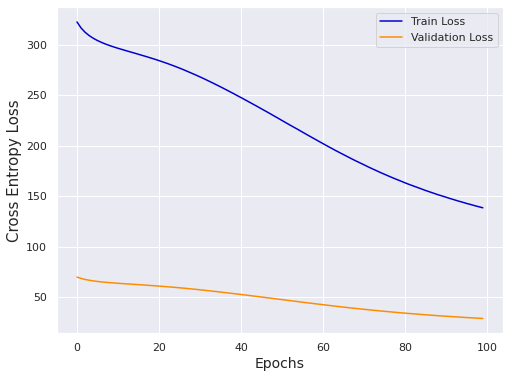

In [34]:
plt.subplots(figsize=(8,6))
plt.plot(np.array(model1.train_loss_arr)*train_length, color='mediumblue',\
         label='Train Loss')
plt.plot(np.array(model1.val_loss_arr)*cv_length, color='darkorange',\
         label='Validation Loss')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.ylabel('Cross Entropy Loss', size=15)
plt.show()

#**Q8)b) Plot of Test and Val Accuracy vs Epochs**

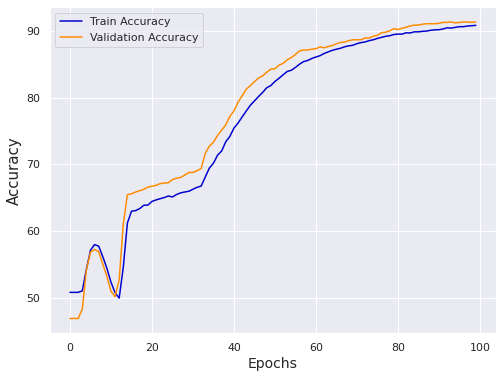

In [16]:
plt.subplots(figsize=(8,6))
plt.plot(model1.train_accuracy, color='mediumblue',label='Train Accuracy')
plt.plot(model1.val_accuracy, color='darkorange',label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.ylabel('Accuracy', size=15)
plt.show()

#**Q8)c) Best Validation Loss vs Hidden Layer Size**

In [41]:
nn2= NeuralNetwork1(hidden_layer_size=2)
model2= Model(nn2, epochs=100, lr=1e-3)
model2.fit()

Epoch-->0 Training Error = 0.042507999352046424 CrossVal Error = 0.042477914770444235
Epoch-->1 Training Error = 0.04242117238044739 CrossVal Error = 0.04240261610349019
Epoch-->2 Training Error = 0.04232851110185896 CrossVal Error = 0.04232774611314138
Epoch-->3 Training Error = 0.042228743749005454 CrossVal Error = 0.04223815548419953
Epoch-->4 Training Error = 0.042130745002201625 CrossVal Error = 0.042156965096791586
Epoch-->5 Training Error = 0.04202900777544294 CrossVal Error = 0.042061815738677975
Epoch-->6 Training Error = 0.04192550046103341 CrossVal Error = 0.041958369811375934
Epoch-->7 Training Error = 0.041819521580423624 CrossVal Error = 0.04186053494612376
Epoch-->8 Training Error = 0.04170992084911891 CrossVal Error = 0.041752596259117127
Epoch-->9 Training Error = 0.04159848952293396 CrossVal Error = 0.041657713890075686
Epoch-->10 Training Error = 0.04148655890566962 CrossVal Error = 0.04155774839719137
Epoch-->11 Training Error = 0.041374420259680064 CrossVal Error =

In [18]:
nn4= NeuralNetwork1(hidden_layer_size=4)
model4= Model(nn4, epochs=100, lr=1e-3)
model4.fit()

Epoch-->0 Training Error = 0.04609940168687276 CrossVal Error = 0.04652548356850942
Epoch-->1 Training Error = 0.045242286545889715 CrossVal Error = 0.045624168554941814
Epoch-->2 Training Error = 0.04462897413117545 CrossVal Error = 0.04494093879063924
Epoch-->3 Training Error = 0.044157615721225736 CrossVal Error = 0.044420095324516295
Epoch-->4 Training Error = 0.04378278121777943 CrossVal Error = 0.043993491808573405
Epoch-->5 Training Error = 0.04346645925726209 CrossVal Error = 0.043629745165507
Epoch-->6 Training Error = 0.043201861373015814 CrossVal Error = 0.04332482361793518
Epoch-->7 Training Error = 0.04296210263456617 CrossVal Error = 0.0430716149409612
Epoch-->8 Training Error = 0.042748685930456436 CrossVal Error = 0.042838683406511945
Epoch-->9 Training Error = 0.04255700675078801 CrossVal Error = 0.04262504247824351
Epoch-->10 Training Error = 0.04237042279754366 CrossVal Error = 0.042422567486763
Epoch-->11 Training Error = 0.04219911241531372 CrossVal Error = 0.04223

In [19]:
nn6= NeuralNetwork1(hidden_layer_size=6)
model6= Model(nn6, epochs=100, lr=1e-3)
model6.fit()

Epoch-->0 Training Error = 0.04382620462349483 CrossVal Error = 0.044072314620018004
Epoch-->1 Training Error = 0.04351516261271068 CrossVal Error = 0.043711079676946006
Epoch-->2 Training Error = 0.04324072108098439 CrossVal Error = 0.043405226985613506
Epoch-->3 Training Error = 0.04300440094300679 CrossVal Error = 0.04313860503832499
Epoch-->4 Training Error = 0.0427912306870733 CrossVal Error = 0.04290333541234334
Epoch-->5 Training Error = 0.0425966408763613 CrossVal Error = 0.042689825654029845
Epoch-->6 Training Error = 0.04240664600474494 CrossVal Error = 0.0424960013628006
Epoch-->7 Training Error = 0.04222909140586853 CrossVal Error = 0.04229479702313741
Epoch-->8 Training Error = 0.04205430459976196 CrossVal Error = 0.04211525662740072
Epoch-->9 Training Error = 0.04188513781343187 CrossVal Error = 0.04193062857786815
Epoch-->10 Training Error = 0.04171633759566716 CrossVal Error = 0.04174911443392436
Epoch-->11 Training Error = 0.041546314443860734 CrossVal Error = 0.041572

In [20]:
nn8= NeuralNetwork1(hidden_layer_size=8)
model8= Model(nn8, epochs=100, lr=1e-3)
model8.fit()

Epoch-->0 Training Error = 0.04401587247848511 CrossVal Error = 0.0437266587416331
Epoch-->1 Training Error = 0.04379044227089201 CrossVal Error = 0.04360862191518148
Epoch-->2 Training Error = 0.043599928217274805 CrossVal Error = 0.04348317031065623
Epoch-->3 Training Error = 0.043431070259639194 CrossVal Error = 0.04335037402311961
Epoch-->4 Training Error = 0.0432731357387134 CrossVal Error = 0.04322385895252228
Epoch-->5 Training Error = 0.04311822479111808 CrossVal Error = 0.0430924866994222
Epoch-->6 Training Error = 0.042965458035469056 CrossVal Error = 0.04295956512292226
Epoch-->7 Training Error = 0.042817145279475624 CrossVal Error = 0.042809739112854
Epoch-->8 Training Error = 0.042663853253637044 CrossVal Error = 0.042666939576466875
Epoch-->9 Training Error = 0.042507488812719076 CrossVal Error = 0.04252125386397044
Epoch-->10 Training Error = 0.04234919370923723 CrossVal Error = 0.04236665638287862
Epoch-->11 Training Error = 0.042185559008802685 CrossVal Error = 0.04220

In [21]:
nn10= NeuralNetwork1(hidden_layer_size=10)
model10= Model(nn10, epochs=100, lr=1e-3)
model10.fit()

Epoch-->0 Training Error = 0.04284884874309812 CrossVal Error = 0.04296090086301168
Epoch-->1 Training Error = 0.042689988817487444 CrossVal Error = 0.042775704820950826
Epoch-->2 Training Error = 0.042526421785354616 CrossVal Error = 0.042603614727656045
Epoch-->3 Training Error = 0.042357929161616736 CrossVal Error = 0.04242744052410126
Epoch-->4 Training Error = 0.04217699978181294 CrossVal Error = 0.04224234946568807
Epoch-->5 Training Error = 0.041986745493752614 CrossVal Error = 0.04204261108239492
Epoch-->6 Training Error = 0.04178383078745433 CrossVal Error = 0.041825618505477904
Epoch-->7 Training Error = 0.041568649683679855 CrossVal Error = 0.04160713811715444
Epoch-->8 Training Error = 0.041344865100724354 CrossVal Error = 0.041380129218101504
Epoch-->9 Training Error = 0.0411035811986242 CrossVal Error = 0.04112546483675639
Epoch-->10 Training Error = 0.0408551847083228 CrossVal Error = 0.04086197944482167
Epoch-->11 Training Error = 0.0405864080957004 CrossVal Error = 0.0

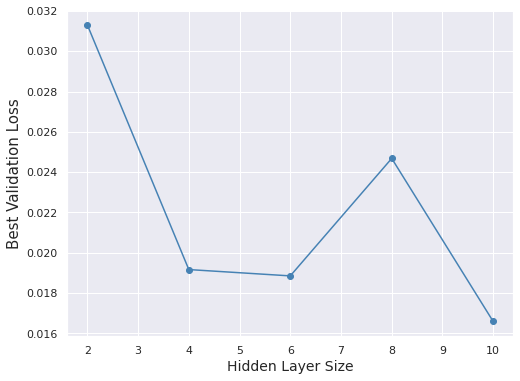

In [42]:
#Loop to get best validation scores
l=[model2,model4,model6,model8,model10]
best_val_loss=[]
for network in l:
    best_val_loss.append(network.val_loss_arr[::-1][0])

plt.subplots(figsize=(8,6))
plt.plot(np.arange(2,11,2), best_val_loss, '-o', color='steelblue')
plt.xlabel('Hidden Layer Size', size=14)
plt.ylabel('Best Validation Loss', size=15)
plt.show()

In [23]:
nn1= NeuralNetwork1()
model_a= Model(nn1, epochs=20, lr=1e-5)
model_a.fit()

Epoch-->0 Training Error = 0.04663348679883139 CrossVal Error = 0.04779295722643535
Epoch-->1 Training Error = 0.046610248599733624 CrossVal Error = 0.04777522691090902
Epoch-->2 Training Error = 0.046598611167499 CrossVal Error = 0.04775779302914937
Epoch-->3 Training Error = 0.046588622416768755 CrossVal Error = 0.04775795904795329
Epoch-->4 Training Error = 0.046589369824954444 CrossVal Error = 0.04775484049320221
Epoch-->5 Training Error = 0.04656553053855896 CrossVal Error = 0.04772763228416443
Epoch-->6 Training Error = 0.04656770927565439 CrossVal Error = 0.04770260500907898
Epoch-->7 Training Error = 0.04653963046414512 CrossVal Error = 0.04769873670736949
Epoch-->8 Training Error = 0.04652707902874265 CrossVal Error = 0.04767562607924143
Epoch-->9 Training Error = 0.04653883266448974 CrossVal Error = 0.04767052392164866
Epoch-->10 Training Error = 0.046508618806089676 CrossVal Error = 0.047660546779632565
Epoch-->11 Training Error = 0.046495510271617344 CrossVal Error = 0.0476

In [24]:
nn1= NeuralNetwork1()
model_b= Model(nn1, epochs=20, lr=1e-4)
model_b.fit()

Epoch-->0 Training Error = 0.04657871960742133 CrossVal Error = 0.04765648305416107
Epoch-->1 Training Error = 0.04644928350618907 CrossVal Error = 0.04750900149345398
Epoch-->2 Training Error = 0.04633616971969604 CrossVal Error = 0.047367088079452516
Epoch-->3 Training Error = 0.04622897324391774 CrossVal Error = 0.047246823787689206
Epoch-->4 Training Error = 0.04613542257036481 CrossVal Error = 0.047127450466156004
Epoch-->5 Training Error = 0.04602394390957696 CrossVal Error = 0.046990954955418905
Epoch-->6 Training Error = 0.04593895604780742 CrossVal Error = 0.04686138248443603
Epoch-->7 Training Error = 0.04583193026270185 CrossVal Error = 0.0467557532787323
Epoch-->8 Training Error = 0.04574140699420656 CrossVal Error = 0.04663678709665934
Epoch-->9 Training Error = 0.045674003354140694 CrossVal Error = 0.04653631325562795
Epoch-->10 Training Error = 0.045575380989483424 CrossVal Error = 0.046434502402941384
Epoch-->11 Training Error = 0.04549389284849167 CrossVal Error = 0.04

In [25]:
nn1= NeuralNetwork1()
model_c= Model(nn1, epochs=20, lr=1e-3)
model_c.fit()

Epoch-->0 Training Error = 0.04609940168687276 CrossVal Error = 0.04652548356850942
Epoch-->1 Training Error = 0.045242286545889715 CrossVal Error = 0.045624168554941814
Epoch-->2 Training Error = 0.04462897413117545 CrossVal Error = 0.04494093879063924
Epoch-->3 Training Error = 0.044157615721225736 CrossVal Error = 0.044420095324516295
Epoch-->4 Training Error = 0.04378278121777943 CrossVal Error = 0.043993491808573405
Epoch-->5 Training Error = 0.04346645925726209 CrossVal Error = 0.043629745165507
Epoch-->6 Training Error = 0.043201861373015814 CrossVal Error = 0.04332482361793518
Epoch-->7 Training Error = 0.04296210263456617 CrossVal Error = 0.0430716149409612
Epoch-->8 Training Error = 0.042748685930456436 CrossVal Error = 0.042838683406511945
Epoch-->9 Training Error = 0.04255700675078801 CrossVal Error = 0.04262504247824351
Epoch-->10 Training Error = 0.04237042279754366 CrossVal Error = 0.042422567486763
Epoch-->11 Training Error = 0.04219911241531372 CrossVal Error = 0.04223

In [26]:
nn1= NeuralNetwork1()
model_d= Model(nn1, epochs=20, lr=1e-2)
model_d.fit()

Epoch-->0 Training Error = 0.043914781195776804 CrossVal Error = 0.04262919127941132
Epoch-->1 Training Error = 0.04161397223813193 CrossVal Error = 0.04082231493790944
Epoch-->2 Training Error = 0.0396647138936179 CrossVal Error = 0.03836165889104207
Epoch-->3 Training Error = 0.03707191922409194 CrossVal Error = 0.03538522926966349
Epoch-->4 Training Error = 0.03398650374582836 CrossVal Error = 0.03197345987955729
Epoch-->5 Training Error = 0.03070302597114018 CrossVal Error = 0.028580094476540883
Epoch-->6 Training Error = 0.027521718182734082 CrossVal Error = 0.025526854117711384
Epoch-->7 Training Error = 0.024724854130830084 CrossVal Error = 0.022966986070076623
Epoch-->8 Training Error = 0.022400327446205275 CrossVal Error = 0.020903526147206624
Epoch-->9 Training Error = 0.020528788604906627 CrossVal Error = 0.019178584724664688
Epoch-->10 Training Error = 0.01903166351360934 CrossVal Error = 0.017855630924304325
Epoch-->11 Training Error = 0.017826739192008972 CrossVal Error =

In [27]:
nn1= NeuralNetwork1()
model_e= Model(nn1, epochs=20, lr=1e-1)
model_e.fit()

Epoch-->0 Training Error = 0.0322639397084713 CrossVal Error = 0.018961983094612757
Epoch-->1 Training Error = 0.015352648765380894 CrossVal Error = 0.01196418168147405
Epoch-->2 Training Error = 0.011041747489678008 CrossVal Error = 0.009993957412739595
Epoch-->3 Training Error = 0.009108321514512812 CrossVal Error = 0.008076396907369296
Epoch-->4 Training Error = 0.007873404241033962 CrossVal Error = 0.007168932965025306
Epoch-->5 Training Error = 0.007133013323215502 CrossVal Error = 0.006640261548260848
Epoch-->6 Training Error = 0.0065433737065510025 CrossVal Error = 0.005918252422163883
Epoch-->7 Training Error = 0.006118778162236725 CrossVal Error = 0.005941002024958531
Epoch-->8 Training Error = 0.0056811257401215174 CrossVal Error = 0.005404439012209574
Epoch-->9 Training Error = 0.005449430139801864 CrossVal Error = 0.0052743311766535045
Epoch-->10 Training Error = 0.0051657088531979495 CrossVal Error = 0.004825801720842719
Epoch-->11 Training Error = 0.004998166558798403 Cro

#**Q8)d) Best Validation Loss vs Learning Rate**

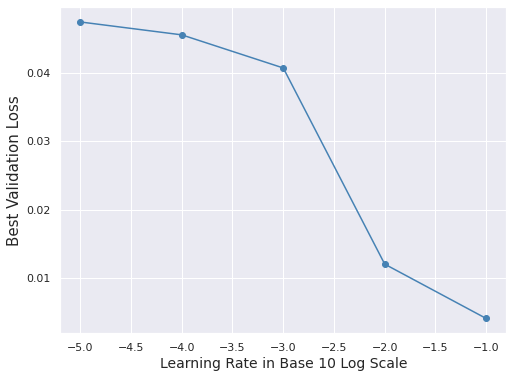

In [28]:
l=[model_a, model_b,model_c, model_d,model_e]
l2= [1e-5,1e-4,1e-3,1e-2,1e-1]
best_val_loss=[]

for model in l:
    best_val_loss.append(model.val_loss_arr[::-1][0])
    
plt.subplots(figsize=(8,6))
plt.plot(np.log(l2)/2.303, best_val_loss, '-o', color='steelblue')
plt.xlabel('Learning Rate in Base 10 Log Scale', size=14)
plt.ylabel('Best Validation Loss', size=15)
plt.show()

#**Q8)e)Test Set Predicted Labels and Test Accuracy + Loss**
I Chose 1e-2 instead of 1e-1 because the error jump due to 1e-1 was way bigger than the jump of 1e-2 and i fekt that using 1e-1 may cause us to overshoot our minima

In [46]:
nn_best= NeuralNetwork1(hidden_layer_size=10)
model_best= Model(nn_best, epochs=100, lr=1e-2)
model_best.fit()

Epoch-->0 Training Error = 0.042069889596530366 CrossVal Error = 0.041134077469507854
Epoch-->1 Training Error = 0.039520966163703375 CrossVal Error = 0.0377757127682368
Epoch-->2 Training Error = 0.03581858651978629 CrossVal Error = 0.033723999718825025
Epoch-->3 Training Error = 0.03182923340371677 CrossVal Error = 0.02976903688907623
Epoch-->4 Training Error = 0.028245926520654132 CrossVal Error = 0.02634163443247477
Epoch-->5 Training Error = 0.025192734616143363 CrossVal Error = 0.023540142595767973
Epoch-->6 Training Error = 0.022689368935567993 CrossVal Error = 0.02125735197464625
Epoch-->7 Training Error = 0.020696613663009233 CrossVal Error = 0.019427824089924495
Epoch-->8 Training Error = 0.01905299391278199 CrossVal Error = 0.017934229513009388
Epoch-->9 Training Error = 0.017640767961740494 CrossVal Error = 0.016586460505922634
Epoch-->10 Training Error = 0.01645032223314047 CrossVal Error = 0.015458710332711538
Epoch-->11 Training Error = 0.015385160072573593 CrossVal Erro

In [47]:
model_best.test()
print('Test set loss is %f'%model_best.test_loss)

Test Set Accuracy is : 99.667
Test set loss is 0.002910


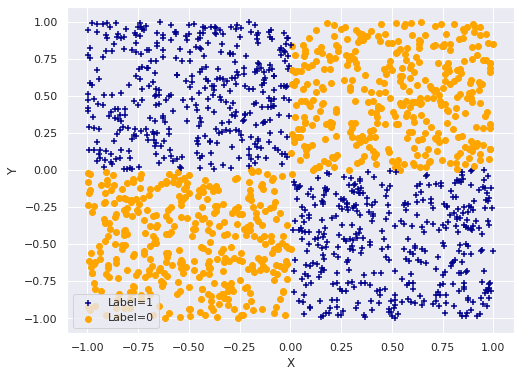

In [48]:
plt.subplots(figsize=(8,6))
for batch in testloader:
    X=batch[0]
    y=batch[1]
    output_prob= nn_best(X)
    batch_pred= torch.argmax(output_prob, dim=1)
    pos=(batch_pred==1).reshape(-1,1)
    neg=(batch_pred==0).reshape(-1,1)
    plt.scatter(X[pos[:,0],0], X[pos[:,0],1], marker='+',color='darkblue')
    plt.scatter(X[neg[:,0],0], X[neg[:,0],1], marker='o',color='orange')
    plt.legend(['Label=1', 'Label=0'])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()